In [11]:
# import libraries
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage
import os

In [12]:
# read original images. Note that the images should be in a folder called "Inputs" in the current working directory
path = os.path.join(os.path.dirname('__file__'), 'Inputs')
list_frameName = os.listdir(path)
frames_2d = []
for i in range(len(list_frameName)):
    img = cv2.imread(os.path.join(path, list_frameName[i]), cv2.IMREAD_GRAYSCALE).astype(float)
    frames_2d.append(img)

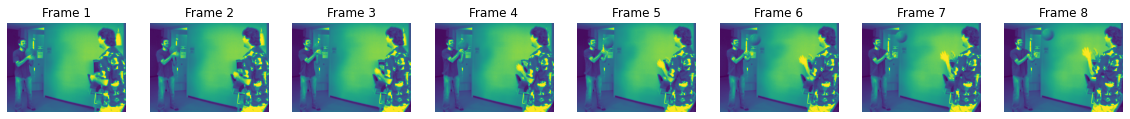

In [13]:
# plot all consecutive 2D frames
fig = plt.figure(figsize=(20, 15))
rows, cols = 1, 8
for i in range(len(frames_2d)):
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(frames_2d[i])
    plt.axis('off')
    plt.title('Frame ' + str(i+1))

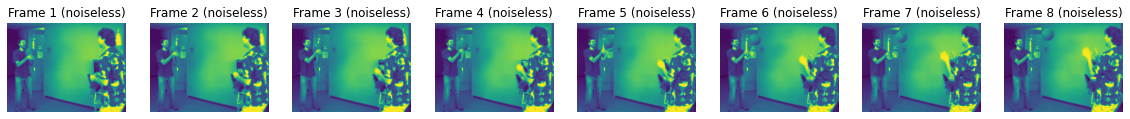

In [14]:
# remove noise from frames using a 5 by 5 Gaussian kernel
frames_noiseless = []
for i in range(len(frames_2d)):
    img = cv2.GaussianBlur(frames_2d[i], (5, 5), 0)
    frames_noiseless.append(img)

fig = plt.figure(figsize=(20, 15))
rows, cols = 1, 8
for i in range(len(frames_noiseless)):
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(frames_noiseless[i])
    plt.axis('off')
    plt.title('Frame ' + str(i+1) + " (noiseless)")

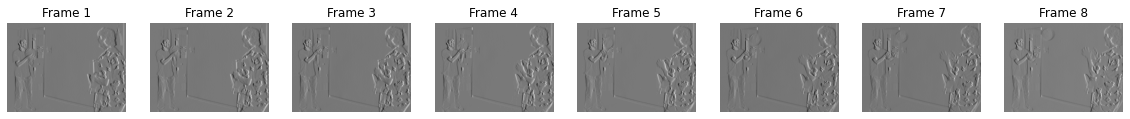

In [15]:
# calculate first derivative in X direction using a 2D filter
x_kernel = np.array([[-1, 1], [-1, 1]]) * 0.25
all_fx = []
for img in frames_noiseless:
    fx = ndimage.convolve(img, x_kernel)
    all_fx.append(fx)

# plot the first derivative of each frame along X
fig = plt.figure(figsize=(20, 15))
rows, cols = 1, 8
for i in range(len(all_fx)):
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(all_fx[i], cmap='gray')
    plt.axis('off')
    plt.title('Frame ' + str(i+1)) 

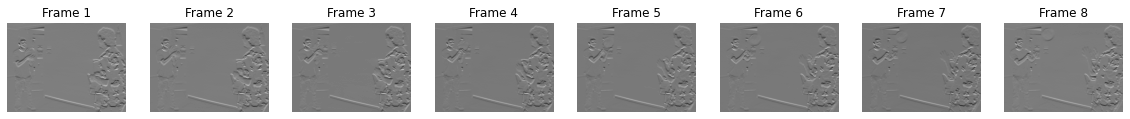

In [16]:
# calculate first derivative in Y direction using a 2D filter
y_kernel = np.array([[-1, -1], [1, 1]]) * 0.25
all_fy = []
for img in frames_noiseless:
    fy = ndimage.convolve(img, y_kernel)
    all_fy.append(fy)

# plot the first derivative of each frame along Y
fig = plt.figure(figsize=(20, 15))
rows, cols = 1, 8
for i in range(len(all_fy)):
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(all_fy[i], cmap='gray')
    plt.axis('off')
    plt.title('Frame ' + str(i+1)) 

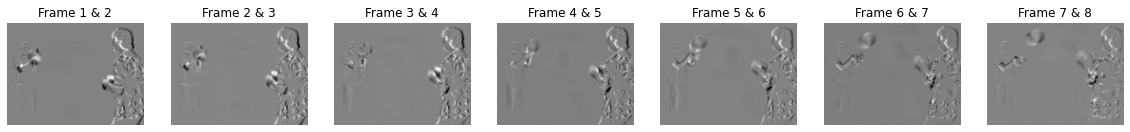

In [17]:
# calculate first derivative in t direction using a 2D filter
t_kernel = np.ones((2, 2)) * 0.25
all_ft = []
for i in range(len(frames_noiseless)-1):
    ft = ndimage.convolve(frames_noiseless[i], -t_kernel) + \
         ndimage.convolve(frames_noiseless[i+1], t_kernel)
    all_ft.append(ft)

# plot the first derivative of each frame along t
fig = plt.figure(figsize=(20, 15))
rows, cols = 1, 7
for i in range(len(all_ft)):
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(all_ft[i], cmap='gray')
    plt.axis('off')
    plt.title('Frame ' + str(i+1) + ' & ' + str(i+2))

In [18]:
# set up initial values for u and v
# for the averages of u and v, a kernel that considers 8 points around each pixel is used
h, w = frames_noiseless[0].shape
u = np.zeros((h, w))
v = np.zeros((h, w))
avg_kernel = np.array([[1/12, 1/6, 1/12], [1/6, 0, 1/6], [1/12, 1/6, 1/12]], float)

In [19]:
# calculate u and v vectors using an iteration approach
fx_sum = sum(all_fx)
fy_sum = sum(all_fy)
ft_sum = sum(all_ft)
alpha = 15
delta = 0.1
iter_counter = 0
while True:
    iter_counter += 1
    u_avg = ndimage.convolve(u, avg_kernel)
    v_avg = ndimage.convolve(v, avg_kernel)
    p = fx_sum * u_avg + fy_sum * v_avg + ft_sum
    d = 4 * alpha**2 + fx_sum**2 + fy_sum**2
    prev = u
    u = u_avg - fx_sum * (p / d)
    v = v_avg - fy_sum * (p / d)
    diff = np.linalg.norm(u - prev, 2)
    
    # converges check (at most 300 iterations)
    if  diff < delta or iter_counter >= 300:
        print("the number of iterations: ", iter_counter)
        break

the number of iterations:  300


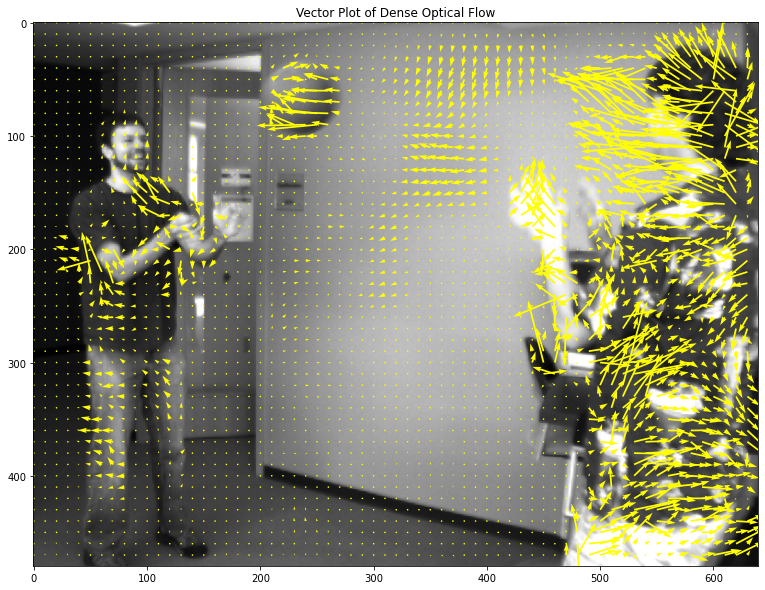

In [20]:
# downsize u and v
u_deci = u[np.ix_(range(0, h, 10), range(0, w, 10))]
v_deci = v[np.ix_(range(0, h, 10), range(0, w, 10))]

# get coordinate for u and v in the original frame
[X,Y] = np.meshgrid(np.arange(w, dtype = 'float64'), np.arange(h, dtype = 'float64'))
X_deci = X[np.ix_(range(0, h, 10), range(0, w, 10))]
Y_deci = Y[np.ix_(range(0, h, 10), range(0, w, 10))]

# plot optical flow field
plt.figure(figsize=(15, 10))
plt.title('Vector Plot of Dense Optical Flow')
plt.imshow(frames_2d[7], cmap = 'gray')
plt.quiver(X_deci, Y_deci, u_deci, v_deci, color='yellow')
plt.show()